# Clustering

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF, LatentDirichletAllocation
from collections import Counter

sns.set_theme()

To start, let's pull in the data from data_exploration.ipynb

In [2]:
comments = pd.read_pickle("../private/top_100_processed.pkl")

Now vectorize it so we can cluster it!

In [3]:
vectorizer = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.5, stop_words="english")
comments_tfidf = vectorizer.fit_transform(comments.text)

Now to try to see if there are any clusters...

In [4]:
svd_model = TruncatedSVD(n_components=2)            # slim down to 2 dimensions!
comments_svd = svd_model.fit_transform(comments_tfidf)

In [5]:
comments_svd.shape

(118299, 2)

<Axes: >

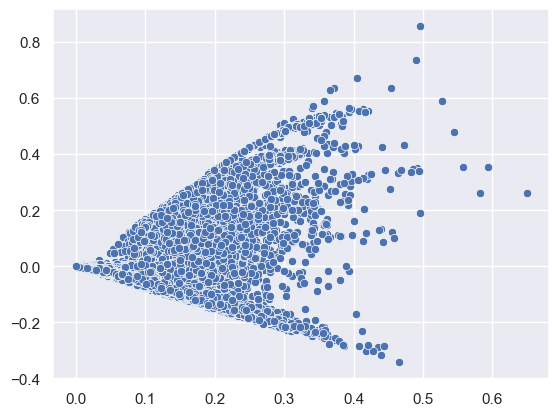

In [6]:
sns.scatterplot(x=comments_svd[:, 0], y=comments_svd[:, 1])

Hmm, no obvious clusters here, but a wide spread! Maybe just a decently high number?

In [7]:
# Slightly modified from activity 7
def display_topics(model, feature_names, num_top_words):
    for i, topic in enumerate(model.components_):
        print(f"Topic {i}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))


I'm going to try both NML and LDA to see which one has better looking clusters.

In [8]:
num_topics = 24

nmf_model = NMF(n_components=num_topics, random_state=0, l1_ratio=0.5, init="nndsvd").fit(comments_tfidf)

display_topics(nmf_model, vectorizer.get_feature_names_out(), 10)

Topic 0:
people time day way got make going right think work
Topic 1:
love absolutely guy fucking omg cats idea style cat creative
Topic 2:
beautiful absolutely work picture thank photo sharing tattoo cat art
Topic 3:
good job boy dad luck really pretty news damn looking
Topic 4:
looks delicious dog damn happy incredible pretty painting straight gorgeous
Topic 5:
amazing work absolutely job look thank sharing omg piece tattoo
Topic 6:
cute cat omg little dog adorable aww super awww look
Topic 7:
great job work idea picture shot look dad news photo
Topic 8:
wow gorgeous really incredible stunning impressive tattoo absolutely thanks job
Topic 9:
awesome job dude fucking work thanks dad picture pretty sharing
Topic 10:
nice work job really shot art tattoo op guy touch
Topic 11:
just say wanted doesn new use maybe ll little watching
Topic 12:
https com imgur jpg www reddit youtu youtube watch png
Topic 13:
cool really pretty super damn thats dad thanks actually tattoo
Topic 14:
did job dog

In [9]:
lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online',
                                      learning_offset=50.,random_state=0).fit(comments_tfidf)

display_topics(lda_model, vectorizer.get_feature_names_out(), 10)

Topic 0:
fuck bro did perfect hank idea kid eat come wrong
Topic 1:
cool incredible tattoo tell gonna sun delicious bless mom head
Topic 2:
wow fucking happy guy looking love just protect handsome impressed
Topic 3:
gif giphy legend rhino fuckin downsized tomorrow dumb trick happens
Topic 4:
https stunning com finally live youtu john wonder hug animals
Topic 5:
joke guys praise skin camera gotta black cutie dick earth
Topic 6:
lol oh got vibes super nintendo rainbow fart 100 tinder
Topic 7:
savevideo wholesome precious 10 af dead 11 btc doggo savevideobot
Topic 8:
dog reddit boy interesting use needs welcome birthday piece hard
Topic 9:
nice damn dude sad king song cake end mr sub
Topic 10:
looks like look need know video don does hilarious good
Topic 11:
god little thats girl asparagus anime ok awww mean bit
Topic 12:
fantastic turtle hate poor sorry moon suit hi knew clearly
Topic 13:
great thank op job thanks sharing doing big ll excellent
Topic 14:
adorable really hope funny wtf sm

Of these two, the results from LDA seem slightly more interesting to me, so I'll take a closer look at it, what's the distribution of subreddit for each of these topics?

In [10]:
# modified from activity 7
def display_topics2(H, W, feature_names, docs, num_top_words, num_top_docs):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print('--------')
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:num_top_docs]

        # build list for frequency distribution
        subs = Counter()
        for doc_index in top_doc_indices:
            subs.update([docs.loc[doc_index].subreddit])
        print(subs.most_common(5))
        print('----------------------------------------------')

lda_W = lda_model.transform(comments_tfidf)    # topics-to-documents matrix
lda_H = lda_model.components_           # word-to-topics matrix
feat_names = vectorizer.get_feature_names_out()

# print top words, top-1 document from each topic
display_topics2(lda_H, lda_W, feat_names, comments, 10, 1000)

Topic 0:
fuck bro did perfect hank idea kid eat come wrong
--------
[('gaming', 42), ('wholesomememes', 35), ('food', 33), ('FoodPorn', 30), ('AnimalsBeingDerps', 28)]
----------------------------------------------
Topic 1:
cool incredible tattoo tell gonna sun delicious bless mom head
--------
[('tattoos', 61), ('food', 42), ('gardening', 32), ('FoodPorn', 32), ('Minecraft', 32)]
----------------------------------------------
Topic 2:
wow fucking happy guy looking love just protect handsome impressed
--------
[('itookapicture', 48), ('food', 37), ('tattoos', 36), ('rarepuppers', 34), ('Awwducational', 29)]
----------------------------------------------
Topic 3:
gif giphy legend rhino fuckin downsized tomorrow dumb trick happens
--------
[('DIY', 43), ('memes', 41), ('tifu', 40), ('cats', 38), ('aww', 35)]
----------------------------------------------
Topic 4:
https stunning com finally live youtu john wonder hug animals
--------
[('photoshopbattles', 52), ('itookapicture', 44), ('tat

I think this might be more interesting if we treat each subreddit as its own document, that might make the clusters more interesting

In [11]:
comments_1000 = pd.read_pickle("../private/top_1000_processed.pkl")
comments_1000.head()

,subreddit,comment_id,text,tokens,num_tokens,num_types,ttr,avg_word_len
0,funny,jg3d9yg,"""Oh my god! That's awful!"" Exactly how you wan...","[``, Oh, my, god, !, That, 's, awful, !, '', E...",24,22,0.916667,3.250000
1,funny,jg3af9r,Her eyes when he stood up.,"[Her, eyes, when, he, stood, up, .]",7,7,1.000000,3.000000
2,funny,jg3782t,the reporter's name is Brad Blanks,"[the, reporter, 's, name, is, Brad, Blanks]",7,7,1.000000,4.142857
3,funny,jg39vhb,**Jennifer:** What are you getting in the way-...,"[*, *, Jennifer, :, *, *, What, are, you, gett...",19,16,0.842105,2.526316
4,funny,jg36sqa,They “were scared…of my brutish height.” 😂,"[They, “, were, scared…of, my, brutish, height...",9,9,1.000000,4.000000


In [12]:
subreddits = comments[["subreddit", "text", "num_tokens", "num_types", "ttr", "avg_word_len"]].groupby("subreddit").agg(
    text=("text", "\n".join),
    total_tokens=("num_tokens", "sum"),
    avg_tokens=("num_tokens", "mean"),
    ttr=("ttr", "mean"),
    avg_word_len=("avg_word_len", "mean"),
)
subreddits.head()

,text,total_tokens,avg_tokens,ttr,avg_word_len
subreddit,,,,,
AdviceAnimals,Why bother even doing an AMA if they are only ...,34504,25.615442,0.903857,3.970445
AnimalsBeingBros,The rescue worker fireman said:\n\n> We rescue...,21064,13.704619,0.946698,4.153795
AnimalsBeingDerps,I love how he picked up on her concern when he...,29333,14.357807,0.939272,4.087738
AnimalsBeingJerks,I’ve long wondered how many hauntings really s...,15235,15.952880,0.933901,4.046530
Art,That land shark behind it is looking for its n...,21498,18.111205,0.931172,3.847400


Now that the comments are grouped as one document per subreddit, lets try clustering again!

In [13]:
vectorizer2 = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.5, stop_words="english")
subreddits_tfidf = vectorizer2.fit_transform(subreddits.text)

In [14]:
svd_model = TruncatedSVD(n_components=2)
subreddits_svd = svd_model.fit_transform(subreddits_tfidf)

<Axes: >

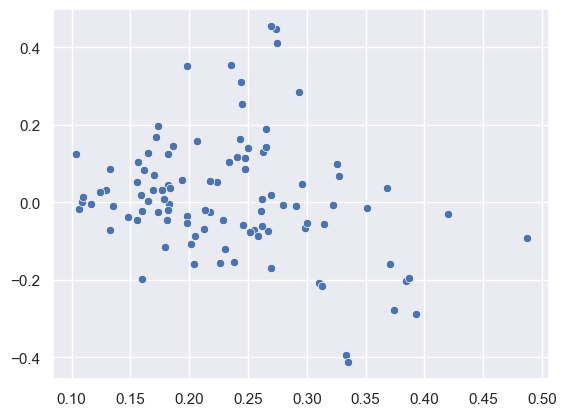

In [15]:
sns.scatterplot(x=subreddits_svd[:, 0], y=subreddits_svd[:, 1])

This looks like a more interesting shape? I think? It's kinda hard to tell... maybe there are some clusters here?

In [16]:
num_topics = 8

nmf_model = NMF(n_components=num_topics, random_state=0, l1_ratio=0.5, init="nndsvd").fit(subreddits_tfidf)

display_topics(nmf_model, vectorizer2.get_feature_names_out(), 10)

Topic 0:
therapist therapy dolly rhino teacher obese mattress cops hospital gun
Topic 1:
cats adorable kitty savevideo sea fish geese giphy elephant puppy
Topic 2:
spez mods apps users apollo buttons subs rif api cancel
Topic 3:
crypto bitcoin btc bank robinhood banks wsb trading img tax
Topic 4:
trump republicans court thomas supreme gop president republican indicted fox
Topic 5:
tattoo gorgeous stunning painting wallpaper turtle portrait album mountains artwork
Topic 6:
pizza delicious cheese cake sauce rice pepperoni bbq recipe sprouts
Topic 7:
nato russia ukraine finland putin pis poland russian sweden rodgers


Oh wow these topics look a lot more like what I was looking for!

In [17]:
lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=5, learning_method='online',
                                      learning_offset=50.,random_state=0).fit(subreddits_tfidf)

display_topics(lda_model, vectorizer2.get_feature_names_out(), 10)

Topic 0:
chris tradition vacation partnership nicely reached chin gpa tinder grass
Topic 1:
warranty douche youngest crock messi na arrest alabama bankruptcy dealer
Topic 2:
trends susan 48 claims supporter mashed 1440p courage gg ethical
Topic 3:
rhinos freshman competitors filing clarify flawless asf medusa poles cape
Topic 4:
spez turtle socialism mixing evolution lion console nooooo doubts balloon
Topic 5:
painting recover trained bills translated afroman homelessness kittens screamed tile
Topic 6:
mods apps hank adorable pin esque utah cab initial senior
Topic 7:
moldy weight fomo prevented brightness ss aunt bruce fundamental takeout


These are... very much not better, let's stick with NMF then.